In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from causalml.inference.meta import XGBTRegressor
from causalml.inference.meta import BaseSLearner, BaseTLearner, BaseRLearner, BaseXLearner
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.dataset import *
from causalml.metrics import *
import sklearn
from sklearn.ensemble import StackingRegressor,VotingRegressor,VotingClassifier
from sklearn import svm
import xgboost as xgb
import random
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from causalml.propensity import GradientBoostedPropensityModel 
from causalml.feature_selection.filters import FilterSelect
np.random.seed(42)

Failed to import duecredit due to No module named 'duecredit'


In [2]:
# 准备数据集，将特征和标签分开
data = pd.read_csv('./data/final_train.csv')  # 读取数据集
data = data.iloc[:,1:]

X = data.drop(['y','treatment'],axis=1) # 特征列
y = data['y']  # 标签列
treatment = data['treatment']  # 处理组标识
feature_names = X.head(0)

print('特征、标签、干预的大小为：',X.shape,y.shape,treatment.shape)
# 将数据集分为训练集和测试集
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, y, treatment, test_size=0.3,random_state=42)

特征、标签、干预的大小为： (30000, 305) (30000,) (30000,)


In [3]:
###############挑选出感兴趣的列
filter_method = FilterSelect()
# F Filter with order 2
method = 'ED'
f_imp = filter_method.get_importance(data, feature_names, 'y', method, 
                                 experiment_group_column="treatment",control_group=0,
                                 treatment_group=1,
                                 n_bins=5,
                                 null_impute='median'
                                 ,order=2)


print(f_imp.iloc[0:10,1])

linear_importance = f_imp.iloc[:,1]
#########选取两个钳位对个特征进行选取
ton_n1 = 125
top_n2 = 175
X_train = X_train[linear_importance[ton_n1:top_n2+1]]
X_test = X_test[linear_importance[ton_n1:top_n2+1]]
print(X_train.shape)

0     x39 * x94
0     x12 * x94
0     x39 * x93
0     x93 + x94
0      x5 * x94
0    x112 * x39
0     x12 * x39
0           x94
0      x4 * x94
0          x112
Name: feature, dtype: object
(27000, 51)


In [4]:
#########计算倾向性得分
kwa = {
            "max_depth": 8,
            "learning_rate": 0.1,
            "n_estimators": 100,
            "objective": "binary:logistic",
            "nthread": -1,
            "colsample_bytree": 0.8,
            "random_state": 42,
           
        }
pro_s =  GradientBoostedPropensityModel (early_stop=False, clip_bounds=(1e-3, 1 - 1e-3), **kwa)

pro_score_train=pro_s.fit_predict(X_train,t_train)
pro_score_test=pro_s.fit_predict(X_test,t_test)



In [5]:
##尝试使用集成模型
def make_models(nums,max_depth_list,n_estimators_list,learning_rate_list,min_child_weight,spw ):
    models=[]
    for i in range(nums):
        models.append((str(i),xgb.XGBRegressor(max_depth=max_depth_list,learning_rate=0.06,gamma=0, min_child_weight = min_child_weight ,reg_alpha=0, # noqa: E501
         n_estimators=n_estimators_list ,scale_pos_weight=spw)))
    return models 

model1=make_models(3,200,200,0.06,spw=0.8,min_child_weight=0.5)  
model2=make_models(3,260,125,0.06,spw=0,min_child_weight=4)
stacking_model1 = StackingRegressor(estimators=model1,cv=5, n_jobs=5)
stacking_model2 = StackingRegressor(estimators=model2,cv=5, n_jobs=5)
voting_model1 = VotingRegressor(estimators=model1)
voting_model2 = VotingRegressor(estimators=model2)


In [6]:
###Try R Learner  此处需要调参


learner_r = BaseRLearner(learner=None,
        outcome_learner=stacking_model1,
        effect_learner=stacking_model2,
        ate_alpha=3,  
        n_fold=5,
        random_state=42)
learner_r.fit(X = X_train, treatment=t_train,y=y_train,p=pro_score_train)


In [7]:
cate_r = learner_r.predict(X=X_test,p=pro_score_test)
print(cate_r.shape)


(3000, 1)


In [8]:

t_test = np.array(t_test).reshape(9000,1)
y_test = np.array(y_test).reshape(9000,1)
data_r = np.concatenate((y_test, t_test,-cate_r), axis=1)
data_r = pd.DataFrame(data_r)
data_r.columns = ['y','w','model']

model     0.659564
Random    0.562608
dtype: float64

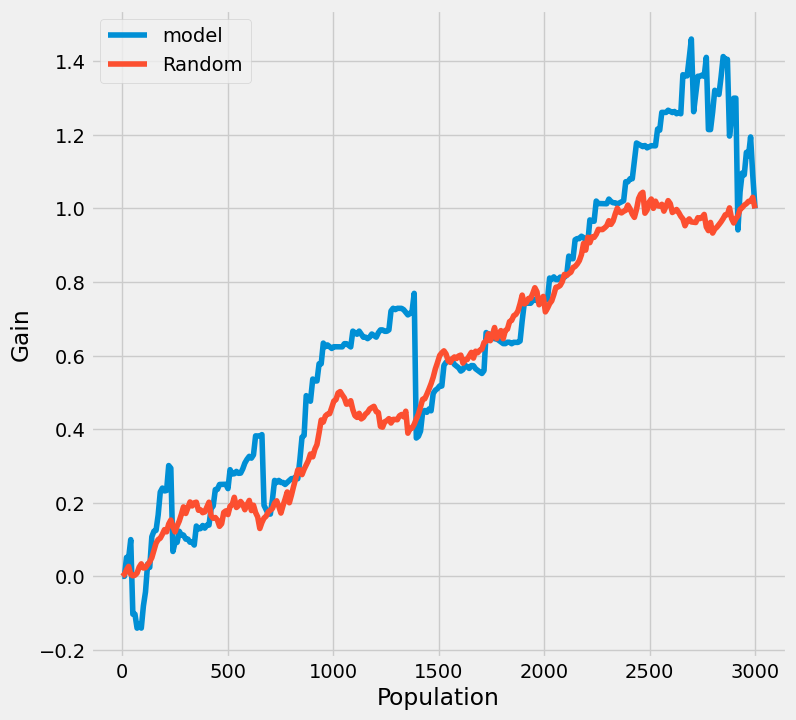

In [9]:
# 计算前t个样本的累计增益
get_cumgain(data_r,normalize=False, random_seed=42)
# 可视化前t个样本的累计增益，即 Uplift Curve
plot_gain(data_r, normalize=True, random_seed=42, n=300, figsize=(8, 8))
auuc_score(df=data_r, normalize=True, tmle=False)


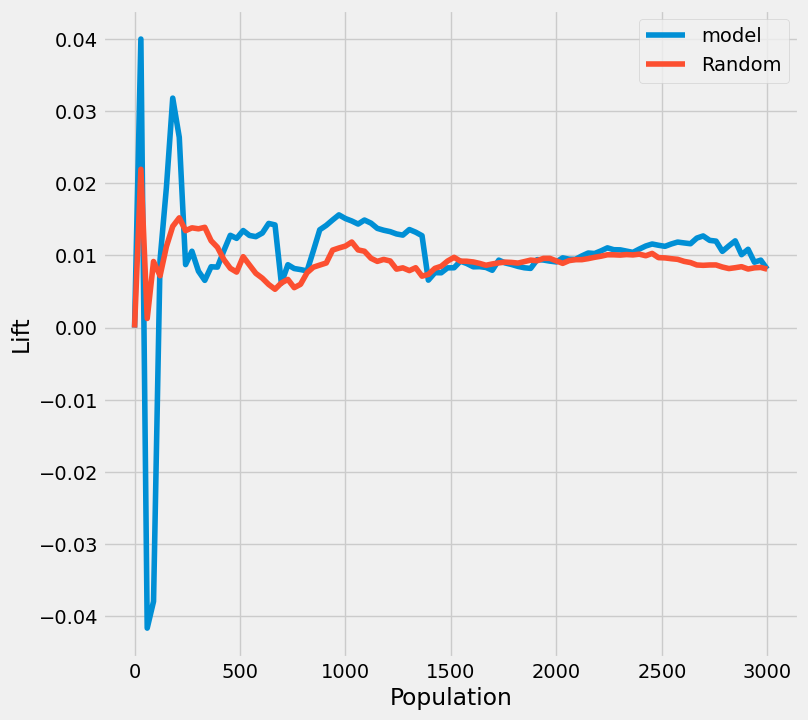

In [10]:
get_cumlift(data_r,random_seed=42)

plot_lift(data_r,  random_seed=42, n=100, figsize=(8, 8))


In [11]:
sub_data = pd.read_csv('./data/Bfinal_test.csv')  # 读取数据集
sub_feature = sub_data.iloc[:,1:].drop('treatment',axis=1)
sub_t = sub_data['treatment']



sub_feature = sub_feature[linear_importance[ton_n1:top_n2+1]]

sub_score=pro_s.fit_predict(sub_feature,sub_t)
tau_test = learner_r.predict(X=sub_feature,p=sub_score)


from sklearn.preprocessing import MinMaxScaler
for i in range(10000):
    if float(tau_test[i]) <= -1:
        print(tau_test[i])
        tau_test[i] = -1
    if float(tau_test[i]) > 1:
        print(tau_test[i])
        tau_test[i]=1

# scaler = MinMaxScaler()
# lift = scaler.fit_transform(cate_r.reshape(-1, 1))
lift = tau_test


In [12]:
sub = pd.DataFrame({'id':sub_data.iloc[:,0],'lift':lift.squeeze()})
sub.to_csv('sub.csv',index=False)